In [1]:
# Import libraries
import os
import warnings
warnings.filterwarnings('ignore')

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#random seeds
torch.manual_seed(44)
np.random.seed(44)

In [4]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        # Initialize the FashionMNIST dataset with an optional transform
        self.transform = transform
        
        # Load FashionMNIST dataset from torchvision
        fashion_dataset = torchvision.datasets.FashionMNIST(root='C:\DATA\WIDS', train=True, download=True)
        
        # Extract labels and images from the dataset
        self.labels = torch.tensor(fashion_dataset.targets)
        self.images = torch.tensor(fashion_dataset.data.numpy().astype('uint8'))

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the label and image for a given index
        
        # Extract label for the current index
        label = self.labels[idx]
        
        # Convert the image data to a PIL Image
        img = Image.fromarray(self.images[idx].numpy(), mode='L')
        
        # Apply the specified transform to the image if available
        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
#printing out first image
dataset = FashionMNIST()
dataset[0][0]

In [10]:
# Define a set of transformations to be applied to the images
transform = transforms.Compose([
        transforms.ToTensor(), # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=(0.5,), std=(0.5,)) # Normalization
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
dataset[0][0] #printing first dataset tensor

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Embedding layer to embed labels (10 classes) into vectors of size 10
        self.label_emb = nn.Embedding(10, 10)
        
        # Sequential model containing fully connected layers with leaky ReLU activation and dropout
        self.model = nn.Sequential(
            nn.Linear(794, 1024),            # Fully connected layer 1: Input size 794, output size 1024
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU activation with slope 0.2
            nn.Dropout(0.3),                 # Dropout layer with dropout probability 0.3
            nn.Linear(1024, 512),            # Fully connected layer 2: Input size 1024, output size 512
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU activation with slope 0.2
            nn.Dropout(0.3),                 # Dropout layer with dropout probability 0.3
            nn.Linear(512, 256),             # Fully connected layer 3: Input size 512, output size 256
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU activation with slope 0.2
            nn.Dropout(0.3),                 # Dropout layer with dropout probability 0.3
            nn.Linear(256, 1),               # Fully connected layer 4: Input size 256, output size 1
            nn.Sigmoid()                     # Sigmoid activation to produce probability-like output
        )
    
    def forward(self, x, labels):
        # Flatten the input tensor x
        x = x.view(x.size(0), 784)
        
        # Embed the labels using the embedding layer
        c = self.label_emb(labels)
        
        # Concatenate the flattened input tensor x and the embedded labels
        x = torch.cat([x, c], 1)
        
        # Pass the concatenated tensor through the sequential model
        out = self.model(x)
        
        # Squeeze the output tensor to remove singleton dimensions
        return out.squeeze()

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Embedding layer to embed labels (10 classes) into vectors of size 10
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),            # Fully connected layer 1: Input size 110, output size 256
            nn.LeakyReLU(0.2, inplace=True),# Leaky ReLU activation with slope 0.2
            nn.Linear(256, 512),            # Fully connected layer 2: Input size 256, output size 512
            nn.LeakyReLU(0.2, inplace=True),# Leaky ReLU activation with slope 0.2
            nn.Linear(512, 1024),           # Fully connected layer 3: Input size 512, output size 1024
            nn.LeakyReLU(0.2, inplace=True),# Leaky ReLU activation with slope 0.2
            nn.Linear(1024, 784),           # Fully connected layer 4: Input size 1024, output size 784
            nn.Tanh()                       # Tanh activation for generating image-like outputs in the range [-1, 1]
        )
    
    def forward(self, z, labels):
        # Reshape the input noise tensor z
        z = z.view(z.size(0), 100)
        
        # Embed the labels using the embedding layer
        c = self.label_emb(labels)
        
        # Concatenate the reshaped noise tensor z and the embedded labels
        x = torch.cat([z, c], 1)
        
        # Pass the concatenated tensor through the sequential model
        out = self.model(x)
        
        # Reshape the output tensor to represent an image-like structure
        return out.view(x.size(0), 28, 28)

In [14]:
# moving them to gpu
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [15]:
# Binary Cross Entropy Loss for binary classification (Real/Fake)
criterion = nn.BCELoss()

# Adam optimizer for the Discriminator and Generator with a learning rate of 1e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [24]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    #generators params grad set to 0
    g_optimizer.zero_grad()
    
    # Generate random noise vector z
    z = Variable(torch.randn(batch_size, 100)).cuda()
    # Generate random labels for the fake images
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    
    # Generate fake images using the Generator
    fake_images = generator(z, fake_labels)
    
    # Get the Discriminator's prediction for the fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculate the Generator's loss
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    # Backpropagate the gradients and update the Generator's parameters
    g_loss.backward()
    g_optimizer.step()
    
    # Return the Generator's loss as a scalar value
    return g_loss.item()

In [25]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    # Calculate the Discriminator's tot loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

Starting epoch 0...
g_loss: 3.429353952407837, d_loss: 0.3926655054092407


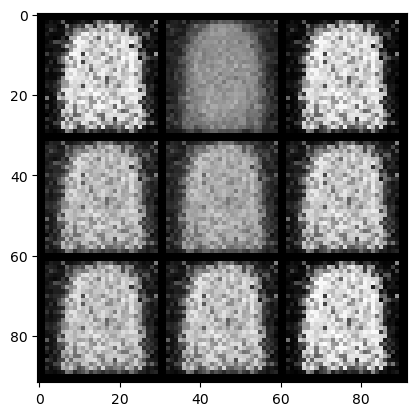

Starting epoch 1...
g_loss: 4.6741943359375, d_loss: 0.46085789799690247


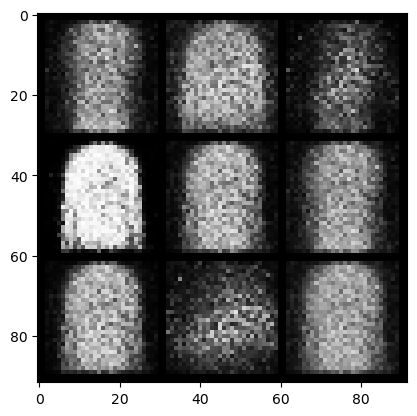

Starting epoch 2...
g_loss: 4.0201497077941895, d_loss: 0.5442408919334412


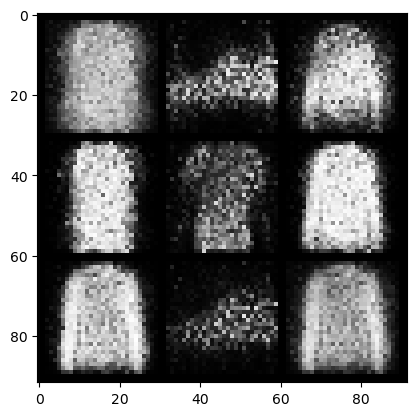

Starting epoch 3...
g_loss: 2.9654593467712402, d_loss: 0.45129385590553284


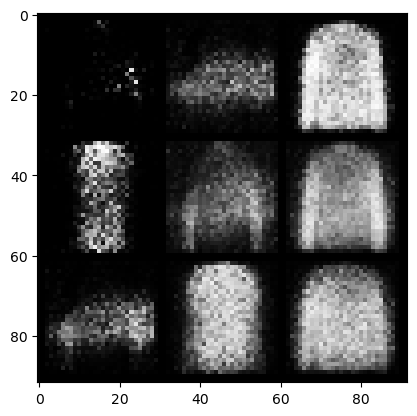

Starting epoch 4...
g_loss: 2.9434049129486084, d_loss: 0.7627289891242981


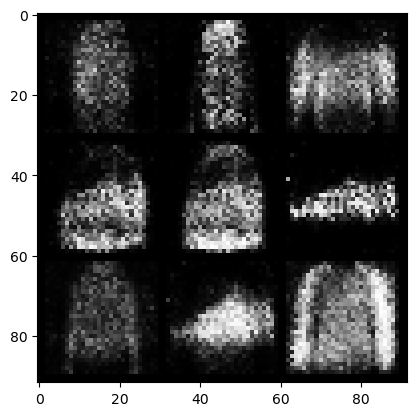

Starting epoch 5...
g_loss: 2.7326927185058594, d_loss: 0.4055565893650055


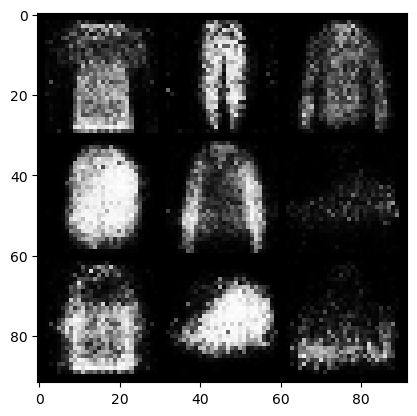

Starting epoch 6...
g_loss: 2.323107957839966, d_loss: 0.7452349662780762


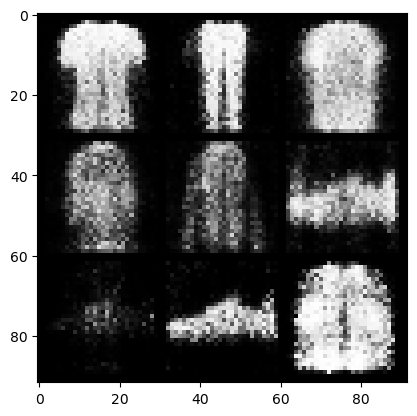

Starting epoch 7...
g_loss: 2.240330457687378, d_loss: 0.995154082775116


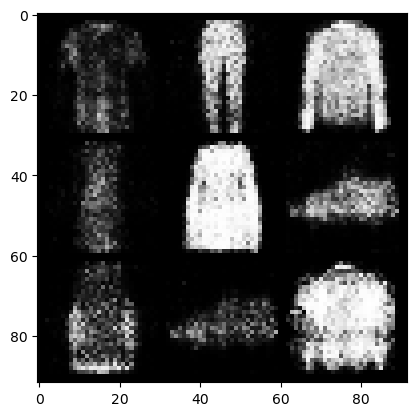

Starting epoch 8...
g_loss: 2.065915822982788, d_loss: 0.5845350623130798


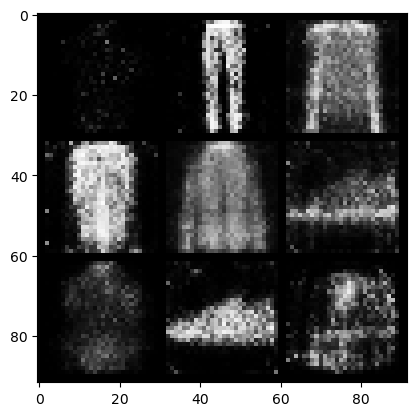

Starting epoch 9...
g_loss: 1.592797040939331, d_loss: 0.8395190238952637


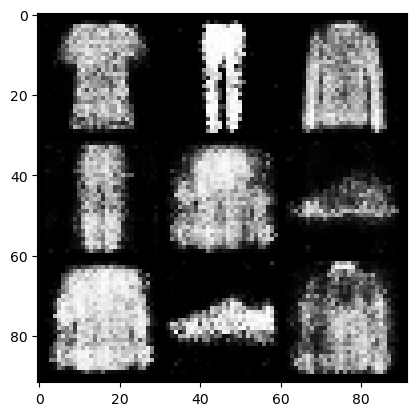

Starting epoch 10...
g_loss: 1.5908560752868652, d_loss: 0.7884483933448792


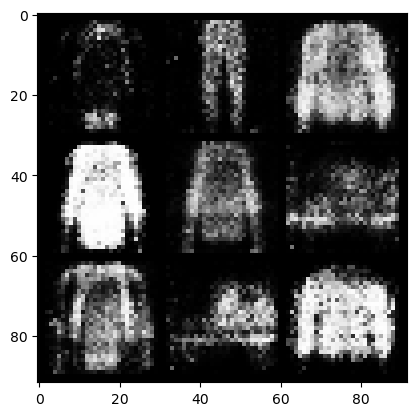

Starting epoch 11...
g_loss: 2.1489033699035645, d_loss: 0.679270327091217


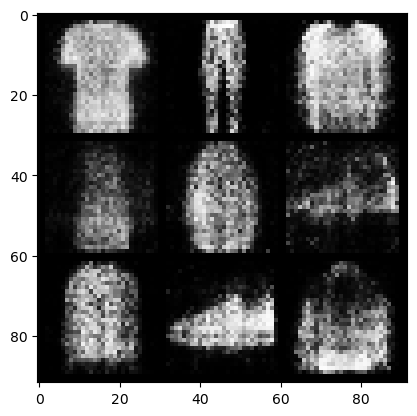

Starting epoch 12...
g_loss: 1.7521936893463135, d_loss: 0.8981492519378662


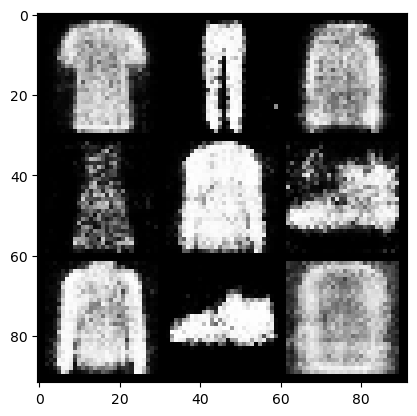

Starting epoch 13...
g_loss: 1.5756609439849854, d_loss: 0.7223682403564453


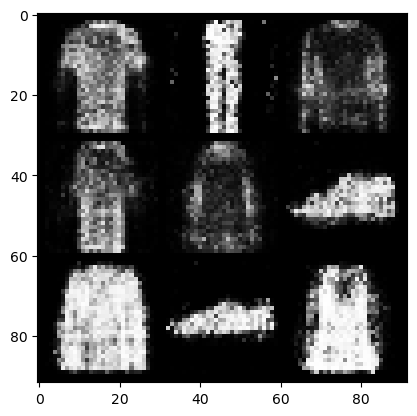

Starting epoch 14...
g_loss: 1.3911651372909546, d_loss: 0.8125765919685364


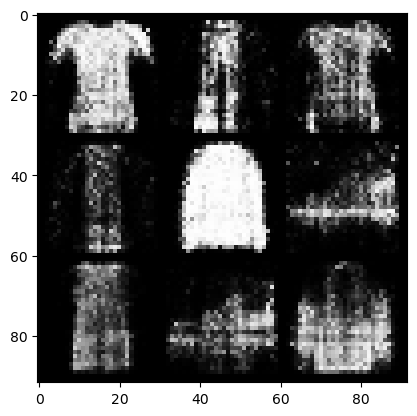

Starting epoch 15...
g_loss: 1.5868830680847168, d_loss: 0.8468173742294312


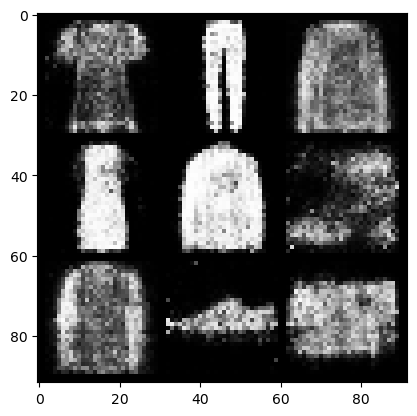

Starting epoch 16...
g_loss: 1.9384387731552124, d_loss: 0.7861910462379456


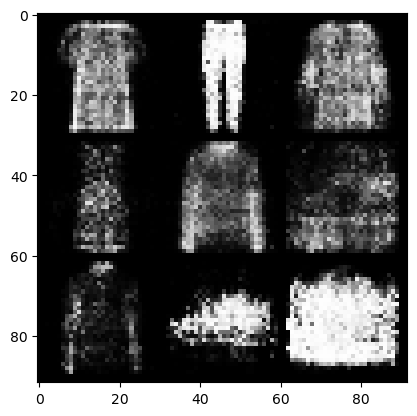

Starting epoch 17...
g_loss: 1.5637203454971313, d_loss: 1.246780276298523


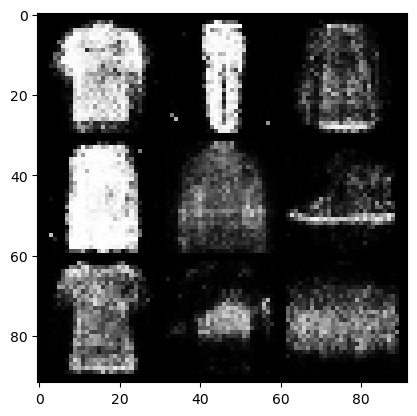

Starting epoch 18...
g_loss: 1.5503299236297607, d_loss: 0.9493957161903381


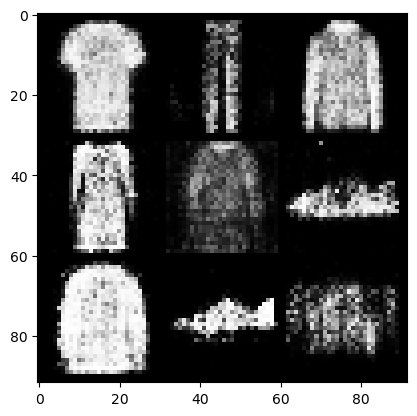

Starting epoch 19...
g_loss: 1.3675830364227295, d_loss: 1.1861798763275146


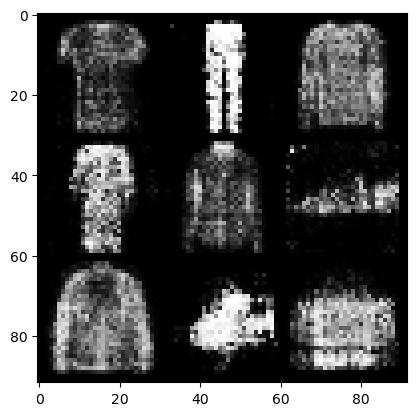

Starting epoch 20...
g_loss: 1.463259220123291, d_loss: 0.968808650970459


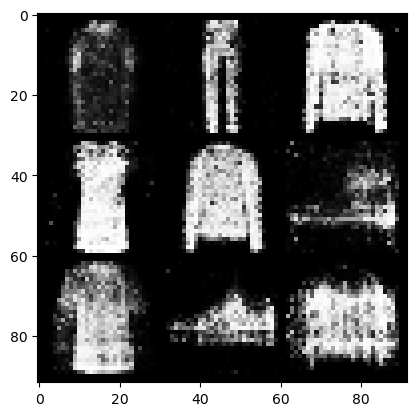

Starting epoch 21...
g_loss: 1.251326560974121, d_loss: 0.9655149579048157


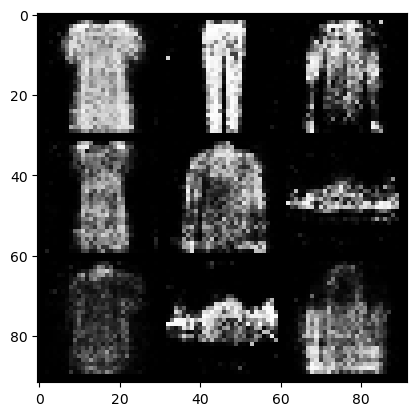

Starting epoch 22...
g_loss: 1.0548529624938965, d_loss: 0.8370954394340515


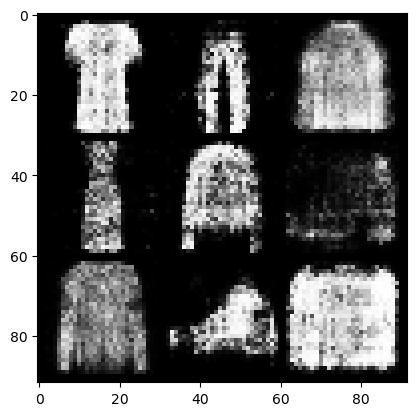

Starting epoch 23...
g_loss: 1.4961919784545898, d_loss: 1.201540231704712


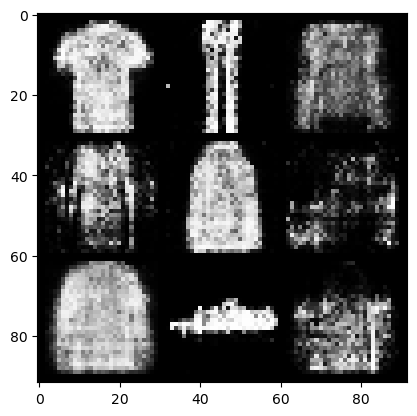

Starting epoch 24...
g_loss: 1.3239576816558838, d_loss: 1.0421429872512817


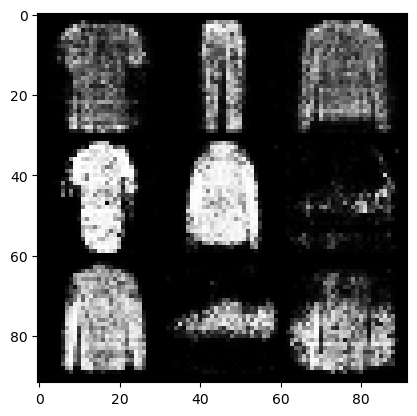

Starting epoch 25...
g_loss: 1.240912914276123, d_loss: 1.0159006118774414


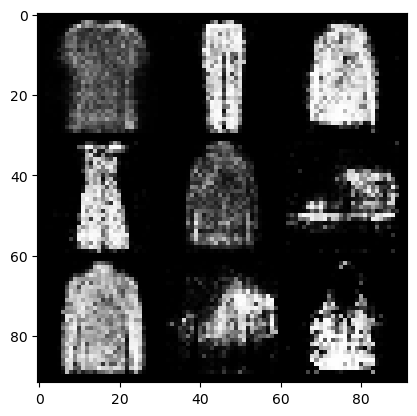

Starting epoch 26...
g_loss: 1.3033583164215088, d_loss: 1.0978602170944214


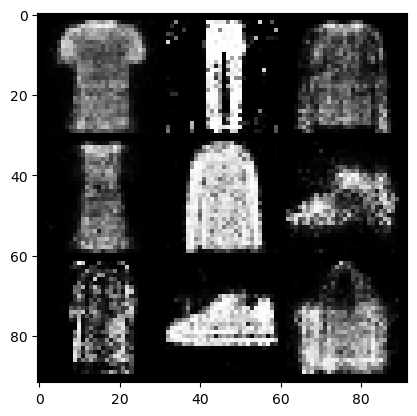

Starting epoch 27...
g_loss: 1.348867416381836, d_loss: 1.1214544773101807


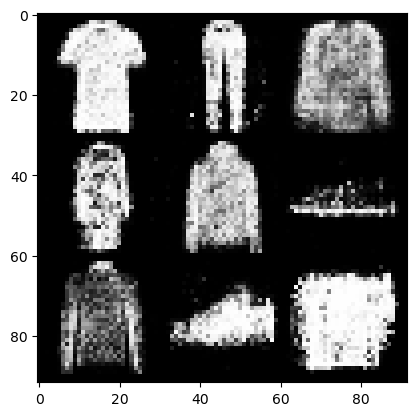

Starting epoch 28...
g_loss: 1.3758599758148193, d_loss: 1.0130383968353271


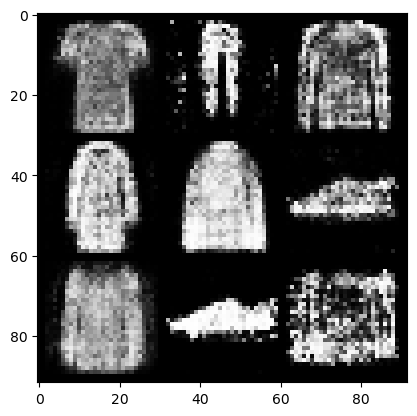

Starting epoch 29...
g_loss: 1.3035383224487305, d_loss: 1.1562169790267944


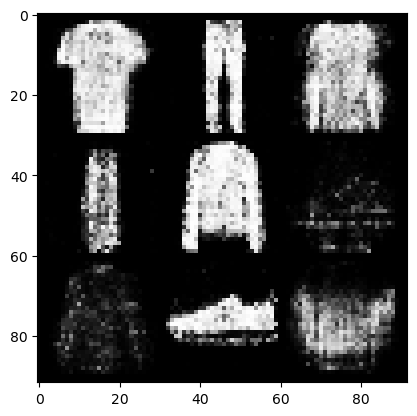

In [26]:
#trianing
num_epochs = 30
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

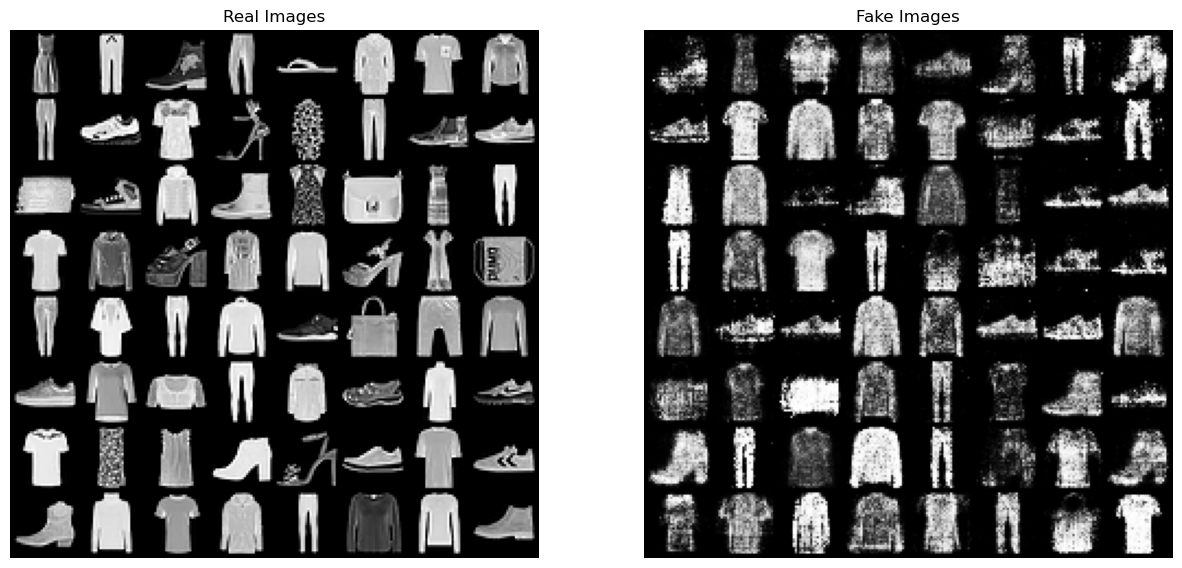

In [35]:

# Set the Generator to evaluation mode
generator.eval()

# Generate real images from the dataset
real_images, real_labels = next(iter(data_loader))
real_images = real_images.cuda()
real_labels = real_labels.cuda()

# Generate fake images using the Generator
z = Variable(torch.randn(real_images.size(0), 100)).cuda()
fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, real_images.size(0)))).cuda()
fake_images = generator(z, fake_labels)

# Create a grid of real images
real_grid = make_grid(real_images, nrow=8, normalize=True).permute(1, 2, 0).cpu().numpy()

# Create a grid of fake images
fake_grid = make_grid(fake_images.unsqueeze(1).data.cpu(), nrow=8, normalize=True).permute(1, 2, 0).numpy()

# Display real vs fake images side by side
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(real_grid)
plt.title('Real Images')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_grid)
plt.title('Fake Images')
plt.axis('off')

plt.show()
